# Distributed Data Analytics
# Exercise Sheet 8
## Sebastian Pineda Arango Mtr. Nr. 246098


Note: In the code folder, the HTML file deploys all the tables correctly, while in the PDF, some tables are cut.

## Exercise 1: Apache Spark Basics

### Part a) Basic Operations on Resilient Distributed Dataset

1. 

In [1]:
#find spark
import findspark
findspark.init()

#import spark context
from pyspark import SparkContext 
sc = SparkContext("local", "First App")

In [43]:
#creating objects
a = ["spark", "rdd", "python", "context", "create", "class"]
b = ["operation", "apache", "scala", "lambda", "parallel", "partition"]


In [44]:
#creating RDD
a_RDD = sc.parallelize(a).map(lambda x: (x,1))
b_RDD = sc.parallelize(b).map(lambda x: (x,1))

In [45]:
a_RDD.leftOuterJoin(b_RDD).collect()

[('python', (1, None)),
 ('class', (1, None)),
 ('spark', (1, None)),
 ('rdd', (1, None)),
 ('context', (1, None)),
 ('create', (1, None))]

In [46]:
a_RDD.rightOuterJoin(b_RDD).collect()

[('scala', (None, 1)),
 ('parallel', (None, 1)),
 ('partition', (None, 1)),
 ('operation', (None, 1)),
 ('apache', (None, 1)),
 ('lambda', (None, 1))]

2.

In [47]:
def count_ch(RDD_words, ch):
    
    """This functions counts how many times ch 
        appers in RDD_words"""
    
    count= RDD_words.map(lambda x: list(x)) \
              .flatMap(lambda x: x) \
              .filter(lambda x: x==ch)\
              .count()
        
    return count


#counting "s" in the list of words
count1 = count_ch(sc.parallelize(a), "s")
count2 = count_ch(sc.parallelize(b), "s")

print("Count in list a:", count1)
print("Count in list b:", count2)

Count in list a: 3
Count in list b: 1


3.

In [48]:
def count_ch2(RDD_words, ch):
    
    """Counts ch in RDD_words using aggregate"""
    seqOp = (lambda x,y : (x[0]+y, x[1]+1))
    combOp = (lambda x,y : (x[0]+y[0], x[1]+y[1]))

    count = RDD_words.map(lambda x: list(x)) \
                .flatMap(lambda x: x) \
                .filter(lambda x: x==ch) \
                .aggregate(("",0), seqOp, combOp)
                
    return count

#counting "s" in the list of words
count1 = count_ch2(sc.parallelize(a), "s")
count2 = count_ch2(sc.parallelize(b), "s")

print("Count in list a:", count1[1])
print("Count in list b:", count2[1])

Count in list a: 3
Count in list b: 1


### Part b) Basic Operations on Resilient Distributed Dataset

In [2]:
#importing SQL context
import pyspark as ps
sqlContext = ps.SQLContext(sc)

In [58]:
#reading the file and its schema
df = sqlContext.read.json("students.json")
df.printSchema()

root
 |-- course: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- points: long (nullable = true)
 |-- s_id: long (nullable = true)



In [59]:
#describing the file
df.describe(["points"]).show()

+-------+------------------+
|summary|            points|
+-------+------------------+
|  count|                19|
|   mean|11.736842105263158|
| stddev|3.3307007147839007|
|    min|                 6|
|    max|                19|
+-------+------------------+



In [60]:
#finding the average
import pyspark.sql.functions as f
mean_points = df.agg(f.avg("points"))
mean_points.show()

+------------------+
|       avg(points)|
+------------------+
|11.736842105263158|
+------------------+



1.

In [61]:
#imputing the column "points"
df = df.na.fill(mean_points.first()[0], ["points"])
df.describe(["points"]).show()

+-------+-----------------+
|summary|           points|
+-------+-----------------+
|  count|               20|
|   mean|             11.7|
| stddev|3.246050231475656|
|    min|                6|
|    max|               19|
+-------+-----------------+



2.

In [62]:
#imputing the columns "dob" and "last name"
df = df.na.fill("unknown", ["dob"])
df = df.na.fill("--",["last_name"])
df.show()

+------------------+------------------+----------+---------+------+----+
|            course|               dob|first_name|last_name|points|s_id|
+------------------+------------------+----------+---------+------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|
|     Deep Learning|  January 13, 1978|      John|       --|    10|   8|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|
|           Physics|  30 December 1987|     Marta|   Brooks|    11|  10|
|    Data Analytics|     June 12, 1975|     Holly| 

3.

In [63]:
import datetime 

def change_date(date):
    """This functions correct the format of the date and 
    outputs the format mm-dd-yyyy"""
    
    d = date[0].replace(",", "")
    if d[0].isdigit():
        
        return datetime.datetime.strptime(d, "%d %B %Y").strftime("%m-%d-%Y")
    elif d =="unknown":
        return "unknown"
    else:
        return datetime.datetime.strptime(d, "%B %d %Y").strftime("%m-%d-%Y")

In [65]:
#changing the date
date2 = df.select("dob").rdd.map(lambda x: (change_date(x),) ).toDF(["date2"])
date2 = date2.withColumn("id", f.monotonically_increasing_id())
df = df.withColumn("id", f.monotonically_increasing_id())

#appending the new changed date
df2 = df.join(date2, "id", "inner").drop("id")
df2.show()

+------------------+------------------+----------+---------+------+----+----------+
|            course|               dob|first_name|last_name|points|s_id|     date2|
+------------------+------------------+----------+---------+------+----+----------+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|10-14-1983|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|09-26-1980|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|06-12-1982|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|04-05-1987|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|11-01-1978|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|02-17-1981|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|01-01-1984|
|     Deep Learning|  January 13, 1978|      John|       --|    10|   8|01-13-1978|
|  Machine Learning|  26 December 1989|    Marcus|   Carson|    15|   9|12-2

4.

In [63]:
#number of seconds in a year = 31536000
#creating the age column by substracting current date with the Date of Birth coumn
df2 = df2.withColumn("age", ((f.unix_timestamp(f.current_date())-f.unix_timestamp(f.col("date2"), format="MM-dd-yyyy"))/31536000).cast("int"))
df2.show()

+------------------+------------------+----------+---------+------+----+----------+----+
|            course|               dob|first_name|last_name|points|s_id|     date2| age|
+------------------+------------------+----------+---------+------+----+----------+----+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|10-14-1983|  35|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|09-26-1980|  38|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|06-12-1982|  37|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|04-05-1987|  32|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|11-01-1978|  40|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|02-17-1981|  38|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|01-01-1984|  35|
|     Deep Learning|  January 13, 1978|      John|       --|    10|   8|01-13-1978|  41|
|  Machine Learning| 

5.

In [66]:
#getting the standard deviation and mean of points
std_points = df.agg(f.stddev("points"))
std_points.show()
std_pd = float(std_points.toPandas().iloc[0])
mean_pd = float(mean_points.toPandas().iloc[0])

+-------------------+
|stddev_samp(points)|
+-------------------+
|  3.246050231475656|
+-------------------+



In [69]:
#setting the points which are greater then tandard deviation to 20
df2 = df2.withColumn("new_points",f.when( f.col("points")-mean_pd> std_pd,20) \
                             .otherwise(f.col("points")))
df2.show()

+------------------+------------------+----------+---------+------+----+----------+----------+
|            course|               dob|first_name|last_name|points|s_id|     date2|new_points|
+------------------+------------------+----------+---------+------+----+----------+----------+
|Humanities and Art|  October 14, 1983|      Alan|      Joe|    10|   1|10-14-1983|        10|
|  Computer Science|September 26, 1980|    Martin|  Genberg|    17|   2|09-26-1980|        20|
|    Graphic Design|     June 12, 1982|     Athur|   Watson|    16|   3|06-12-1982|        20|
|    Graphic Design|     April 5, 1987|  Anabelle|  Sanberg|    12|   4|04-05-1987|        12|
|        Psychology|  November 1, 1978|      Kira| Schommer|    11|   5|11-01-1978|        11|
|          Business|  17 February 1981| Christian|   Kiriam|    10|   6|02-17-1981|        10|
|  Machine Learning|    1 January 1984|   Barbara|  Ballard|    14|   7|01-01-1984|        14|
|     Deep Learning|  January 13, 1978|      John|

6.

Text(0,0.5,'Frequency')

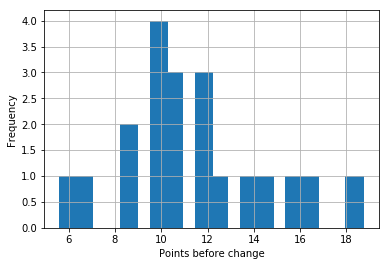

In [68]:
#ploting histograms of the points
import matplotlib.pyplot as plt
%matplotlib inline

hists= df2.select("points").rdd.flatMap(lambda x: x).histogram(20)
plt.bar(hists[0][:-1], hists[1])
plt.grid()
plt.xlabel("Points before change")
plt.ylabel("Frequency")


Text(0,0.5,'Frequency')

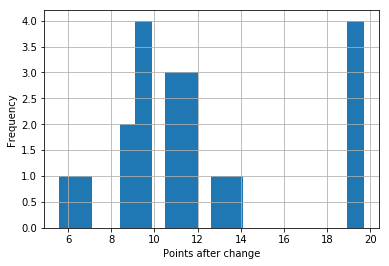

In [75]:
hists= df2.select("new_points").rdd.flatMap(lambda x: x).histogram(20)
plt.bar(hists[0][:-1], hists[1])
plt.grid()
plt.xlabel("Points after change")
plt.ylabel("Frequency")

## Exercise 2: Apache Spark Basics

In [93]:
#reading tags and printing first row
data = sc.textFile("tags.dat")
data.first()

'15::4973::excellent!::1215184630'

In [94]:
#processing the rows with mappers
df = data.map(lambda x: x.split("::")) \
         .map(lambda x: (int(x[0]), int(x[1]), x[2], int(x[3])))
df.first()

(15, 4973, 'excellent!', 1215184630)

In [95]:
#transforming to DataFrame
df = df.toDF(["UserID", "MovieID", "Tag", "Timestamp"])
df.show(10)

+------+-------+---------------+----------+
|UserID|MovieID|            Tag| Timestamp|
+------+-------+---------------+----------+
|    15|   4973|     excellent!|1215184630|
|    20|   1747|       politics|1188263867|
|    20|   1747|         satire|1188263867|
|    20|   2424|chick flick 212|1188263835|
|    20|   2424|          hanks|1188263835|
|    20|   2424|           ryan|1188263835|
|    20|   2947|         action|1188263755|
|    20|   2947|           bond|1188263756|
|    20|   3033|          spoof|1188263880|
|    20|   3033|      star wars|1188263880|
+------+-------+---------------+----------+
only showing top 10 rows



1.

To separate the tags session, we create two flags: 1) change user (it means, the previous and current user are different) and 2) change session (It means, the difference between the last and current timestamp is greater than 30 mins. Base on those two flags, we create a SessionID that allows to identify different sessions in further processing.

In [102]:
from pyspark.sql import Window

w = Window.orderBy( f.asc('UserID'), f.asc('Timestamp'))

df = df.withColumn("TimestampLag",  f.lag("Timestamp").over(w)) \
        .withColumn("UserLag", f.lag("UserID").over(w)) \
        .withColumn("ChangeUser", f.when((f.col("UserID")!=f.col("UserLag")), 1) \
                                  .otherwise(0))
        
df = df.withColumn("ChangeSession", f.when((f.col("Timestamp")-f.col("TimestampLag"))< 1800, f.col("ChangeUser")) \
                                  .otherwise(1)) \
        .withColumn("SessionID", f.sum("ChangeSession").over(w)) 
df.show(20)

+------+-------+--------------------+----------+------------+----------+-------------+---------+------------+-------+
|UserID|MovieID|                 Tag| Timestamp|TimestampLag|ChangeUser|ChangeSession|SessionID|TimestampDif|UserLag|
+------+-------+--------------------+----------+------------+----------+-------------+---------+------------+-------+
|    15|   4973|          excellent!|1215184630|        null|         0|            1|        1|           0|   null|
|    20|   2947|              action|1188263755|  1215184630|         1|            1|        2|           0|     15|
|    20|   2947|                bond|1188263756|  1188263755|         0|            0|        2|           1|     20|
|    20|   7438|              bloody|1188263801|  1188263756|         0|            0|        2|          45|     20|
|    20|   7438|             kung fu|1188263801|  1188263801|         0|            0|        2|           0|     20|
|    20|   7438|           Tarantino|1188263801|  118826

2.

Now find the tags per session for every user (tag frequency). This is used to calculate the man and standard deviation of start frequency.

In [101]:
TagsPerSession = df.groupBy("SessionID", "UserID").count().withColumnRenamed("count", "TagsPerSession")
TagsPerSession.show(10)

+---------+------+--------------+
|SessionID|UserID|TagsPerSession|
+---------+------+--------------+
|        1|    15|             1|
|        2|    20|            12|
|        3|    21|             2|
|        4|    25|             1|
|        5|    25|             1|
|        6|    31|             5|
|        7|    32|             1|
|        8|    39|             5|
|        9|    48|             2|
|       10|    49|            15|
+---------+------+--------------+
only showing top 10 rows



3.

Now we find the mean and the standard deviation of tags per user.

In [103]:
#mean tags per user
MeanTagsPerUser =  TagsPerSession.groupBy("UserID").mean("TagsPerSession") \
                               .withColumnRenamed("avg(TagsPerSession)", "MeanTagsPerUser") \
                               .withColumn("MeanTagsPerUser", f.round("MeanTagsPerUser", 4 ))
MeanTagsPerUser.show()

+------+---------------+
|UserID|MeanTagsPerUser|
+------+---------------+
|    15|            1.0|
|    20|           12.0|
|    21|            2.0|
|    25|            1.0|
|    31|            5.0|
|    32|            1.0|
|    39|            5.0|
|    48|            2.0|
|    49|           15.0|
|    75|            1.0|
|    78|            1.0|
|   109|         2.7778|
|   127|           26.0|
|   133|            5.0|
|   146|         4.9489|
|   147|            2.0|
|   170|            1.0|
|   175|            1.0|
|   181|            4.0|
|   190|            6.5|
+------+---------------+
only showing top 20 rows



In [104]:
#standard deviation
StdTagsPerUser =  TagsPerSession.groupBy("UserID").agg(f.stddev_pop("TagsPerSession")) \
                               .withColumnRenamed("stddev_pop(TagsPerSession)", "StdTagsPerUser") \
                               .withColumn("StdTagsPerUser", f.round("StdTagsPerUser", 4))
StdTagsPerUser.show()

+------+--------------+
|UserID|StdTagsPerUser|
+------+--------------+
|    15|           0.0|
|    20|           0.0|
|    21|           0.0|
|    25|           0.0|
|    31|           0.0|
|    32|           0.0|
|    39|           0.0|
|    48|           0.0|
|    49|           0.0|
|    75|           0.0|
|    78|           0.0|
|   109|        3.0832|
|   127|           0.0|
|   133|           0.0|
|   146|        8.9965|
|   147|           0.0|
|   170|           0.0|
|   175|           0.0|
|   181|           0.0|
|   190|        6.0622|
+------+--------------+
only showing top 20 rows



4.

Computing the mean and standard deviation across all users.

In [107]:
statistics = TagsPerSession.agg(f.avg("TagsPerSession"), f.stddev("TagsPerSession")) \
                               .withColumnRenamed("avg(TagsPerSession)", "MeanTags") \
                               .withColumn("MeanTags", f.round("MeanTags", 4)) \
                               .withColumnRenamed("stddev_samp(TagsPerSession)", "StdTags") \
                               .withColumn("StdTags", f.round("StdTags", 4)) 
                                
statistics.show()

+--------+-------+
|MeanTags|StdTags|
+--------+-------+
|  7.3001|22.2643|
+--------+-------+



In [108]:
mean, std = statistics.toPandas().iloc[0,]

5.

List of users with a mean tagging frequency within two standar deviation from the mean frequency of all users.

In [109]:
df2 = MeanTagsPerUser.filter( f.abs(f.col("MeanTagsPerUser") -mean) < 2*std).select("UserID")
df2.show(10)

+------+
|UserID|
+------+
|    15|
|    20|
|    21|
|    25|
|    31|
|    32|
|    39|
|    48|
|    49|
|    75|
+------+
only showing top 10 rows



## Bonus: Analysis of Movie Dataset Using Apache Spark Mapreduce

In [112]:
import os
import pyspark.sql.types as types

data_schema = [types.StructField('userId', types.IntegerType(), True),
               types.StructField('movieId', types.IntegerType(), True),
               types.StructField('rating', types.DoubleType(), True),
               types.StructField('timestamp', types.DoubleType(), True)]

data = sqlContext.read.csv(os.path.join("ml-latest-small","ratings.csv"), header=True, schema = types.StructType(data_schema))
data.show(3)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|9.64982703E8|
|     1|      3|   4.0|9.64981247E8|
|     1|      6|   4.0|9.64982224E8|
+------+-------+------+------------+
only showing top 3 rows



1.

Finding the movie titles with the maximum average ratings (there are several of them : 256).

In [116]:
MeanRatingPerMovie = data.groupBy("movieId").mean("rating").orderBy(f.desc("avg(rating)")).show(5)

+-------+-----------+
|movieId|avg(rating)|
+-------+-----------+
|   8911|        5.0|
| 150554|        5.0|
|  67618|        5.0|
|    496|        5.0|
|    148|        5.0|
+-------+-----------+
only showing top 5 rows



In [117]:
MaxRatings = data.groupBy("movieId").mean("rating").filter(f.col("avg(rating)")==5.0)
MaxRatings.show(5)
print("Movies with maximal avg rating:", MaxRatings.count())

+-------+-----------+
|movieId|avg(rating)|
+-------+-----------+
|    148|        5.0|
|    496|        5.0|
|  67618|        5.0|
| 150554|        5.0|
| 142444|        5.0|
+-------+-----------+
only showing top 5 rows

Movies with maximal avg rating: 296


2.

We see that the User with ID: 139 assigns the lowest average ratings among all the users that have more than 40 ratings.

In [118]:
data.groupBy("UserId").agg( f.count("rating") ,f.mean("rating")) \
                        .filter(f.col("count(rating)")>40) \
                        .orderBy(f.asc("avg(rating)")).show(3)

+------+-------------+------------------+
|UserId|count(rating)|       avg(rating)|
+------+-------------+------------------+
|   139|          194|2.1443298969072164|
|   153|          179| 2.217877094972067|
|   567|          385|2.2454545454545456|
+------+-------------+------------------+
only showing top 3 rows



3.

We see that the western movies have the hgihest average ratings.

In [119]:
movies = sqlContext.read.csv(os.path.join("ml-latest-small","movies.csv"), header=True)
movies = movies.withColumn("id", f.monotonically_increasing_id())
data = data.withColumn("id", f.monotonically_increasing_id())
movies = movies.join(data, "id", "inner")
movies = movies.select("genres", "rating").rdd.flatMap(lambda x: [(i, (1, x[1])) for i in x[0].split("|")]) \
                                                .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])) \
                                                .mapValues(lambda x: x[0]/x[1]  )

In [120]:
movies.reduce(lambda x,y: max(x, y))

('Western', 0.2950530035335689)

In [121]:
movies.take(5)

[('Adventure', 0.27985818745845337),
 ('Animation', 0.27356167450190283),
 ('Children', 0.2797556351379819),
 ('Comedy', 0.28370722864264675),
 ('Fantasy', 0.2761432116270826)]

## References

* https://www.coursera.org/lecture/big-data-machine-learning/handling-missing-values-in-spark-Goh1z
* "Learning PySpark" by Tomasz Drabas and Denny Lee
* https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html
* https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/